### 1. Business Understanding

O Walmart enfrenta um aumento significativo nas reclamações de produtos não entregues em compras online. O objetivo deste projeto é identificar padrões de possíveis fraudes nas entregas da região central da Flórida, onde itens marcados como entregues não foram recebidos pelos clientes. O foco é descobrir se a responsabilidade recai sobre entregadores, consumidores ou falhas no processo.  

In [176]:
# Pedidos com itens faltando
pct_faltando = len(df) / len(df_original) * 100
print(f"Pedidos com itens faltando: {len(df)} ({pct_faltando:.2f}%)")

# Soma do preço dos itens faltantes
soma_price = df_produto['price'].sum()
print(f"Soma do preço dos itens faltantes: ${soma_price:.2f}")

Pedidos com itens faltando: 0 (0.00%)
Soma do preço dos itens faltantes: $149372.61


### 2. EDA

EDA é uma análise exploratória dos dados, tem por objetivo verificar a qualidade dos dados e como os dados se conectam entre sim, primeiramente vamos obter os dados que estão disponíveis no DataWorld.
Para essa etapa é usado SQL, e com isso  criado duas tabelas, uma geral e outra a parte com os produtos, uma ordem pode ter vários produtos e nessas ordens os produtos ficavam na mesma linha, foi necessário pivotar essa coluna onde cada produto fica em cada linha para poder fazer o estudo produto por produto.  

*utilizo a API para obter e para isso é necessário obter uma chave única, caso queira utilizar esse trabalho, será necessário criar uma chave de api em sua própria conta.*  

In [177]:
# Obtenção dos Dados

import datadotworld as dw
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

# Carrega as variáveis de ambiente
load_dotenv()  

# Dataset e query
dataset_key = 'jerrys/introduction-to-data-analytics'
query_geral = """
SELECT 
    orders.order_id,
    date,
    order_amount,
    region,
    items_delivered,
    items_missing,
    delivery_hour,
    orders.driver_id,
    orders.customer_id,
    product_id_1,
    product_id_2,
    product_id_3,
    driver_name,
    age AS driver_age,
    trips,
    customer_name,
    customer_age
FROM orders
LEFT JOIN
    missing_items_data
    ON missing_items_data.order_id = orders.order_id
INNER JOIN
    drivers_data
    ON drivers_data.driver_id = orders.driver_id
INNER JOIN
    customers_data
    ON customers_data.customer_id = orders.customer_id
"""

results = dw.query(dataset_key, query_geral)
df = results.dataframe

query_produto = """
-- --------------------------- Tabela Pivotada de Produtos Perdidos
WITH missing_products AS (
    SELECT order_id, product
    FROM (
        SELECT 
            order_id, 
            product_id_1 AS produto_1, 
            product_id_2 AS produto_2, 
            product_id_3 AS produto_3
        FROM missing_items_data
    ) src
    UNPIVOT (
        product FOR produto_coluna IN (produto_1, produto_2, produto_3)
    )
)

-- --------------------------- MAIN QUERY
SELECT 
    order_id,
    product,
    product_name,
    category,
    price
FROM missing_products
INNER JOIN
    products_data
    ON products_data.produc_id = missing_products.product
"""

results = dw.query(dataset_key, query_produto)
df_produto = results.dataframe

# Exibe as primeiras linhas dos DataFrames
print('Tabela Fato Pedido')
display(df.head(3))
print('Tabela Produtos')
display(df_produto.head())

Tabela Fato Pedido


,order_id,date,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,product_id_1,product_id_2,product_id_3,driver_name,driver_age,trips,customer_name,customer_age
0,d862b950-4549-48e6-9b40-c171102265c9,2023-10-26,447.16,Sanford,5,0,02:59:05,WDID10071,WCID6128,None,None,None,Chad Medina,19,20,Robert Wilson,23
1,36dcb3d0-cae6-4ed6-af16-0bbc87cf44c2,2023-10-26,375.40,Winter Park,9,0,16:39:34,WDID10185,WCID6039,None,None,None,Lisa Camacho,20,20,Matthew Lutz,72
2,5df7173b-988d-42fb-b0ff-b5d0751c5597,2023-10-26,218.47,Winter Park,8,0,15:12:16,WDID10903,WCID5289,None,None,None,John Collins,44,27,Brandon Young,64


Tabela Produtos


,order_id,product,product_name,category,price
0,c7a343f7-3f1d-497c-8004-b9ede2d48fb1,PWPX0982761090982,Kellogg's Frosties,Supermarket,12.53
1,20698293-8399-4fda-af1e-b61a9ebb8a0a,PWPX0982761090983,Uncured Bacon,Supermarket,4.67
2,d7f690a0-c1c2-4b36-b05f-2b7e641ea1ac,PWPX0982761090984,Whole Milk,Supermarket,9.95
3,d5cea1eb-7016-451b-9426-51973f4d6e14,PWPX0982761090985,Organic Bananas,Supermarket,3.94
4,2f7cbda8-793a-4a1d-bb66-3a514bee5dc4,PWPX0982761090986,Sourdough Bread,Supermarket,19.77


##### 2.1 Data Preparation

Aqui vamos preparar os dados para que seja possível fazer as análises.  
Ainda nessa etapa será feita uma preparação inicial, o CRISP-DM permite que volte nessa etapa caso seja necessário após a etapa de Data Undestanding.  
Aqui vamos criar dois dataset's, um completo e outro apenas com as ordens que possuem itens faltantes.

----- Se for acrescentar uma coluna nova, será nessa etapa.

In [178]:
# Criação de um dataset completo e outro apenas com ordens que possuem itens faltantes
df_filtrado = df[df['items_missing'] > 0] # type: ignore

df_original = df.copy()  # Cria uma cópia do DataFrame original para referência futura
df = df_filtrado[df_filtrado['product_id_1'].notnull()] # a variável df agora contém apenas as ordens com itens faltantes

Ao analisar os registros da tabela 'products' foi identificado que a coluna 'category' está incorreta.  
Um exemplo é o produto abaixo que é um cereal categorizado como 'Cuidado Pessoal' 

product_id | product_name | category | price |  
----------|-------------|-----------|------------|  
PWPX0982761091130 | Frosted Flakes | Personal Care | Personal Care | 18.16 |  

Para resolver esse problema utilizei os recursos de IA Generativa Gemini, para reclassificar todos os produtos.

In [179]:
correcao_categorias = {
    'PWPX0982761090982': 'Pantry',
    'PWPX0982761090983': 'Supermarket',
    'PWPX0982761090984': 'Dairy',
    'PWPX0982761090985': 'Produce',
    'PWPX0982761090986': 'Bakery',
    'PWPX0982761090987': 'Dairy',
    'PWPX0982761090988': 'Dairy',
    'PWPX0982761090989': 'Pantry',
    'PWPX0982761090990': 'Frozen',
    'PWPX0982761090991': 'Pantry',
    'PWPX0982761090992': 'Pantry',
    'PWPX0982761090993': 'Pantry',
    'PWPX0982761090994': 'Pantry',
    'PWPX0982761090995': 'Pantry',
    'PWPX0982761090996': 'Dairy',
    'PWPX0982761090997': 'Supermarket',
    'PWPX0982761090998': 'Produce',
    'PWPX0982761090999': 'Pantry',
    'PWPX0982761091000': 'Produce',
    'PWPX0982761091001': 'Frozen',
    'PWPX0982761091002': 'Snacks',
    'PWPX0982761091003': 'Supermarket',
    'PWPX0982761091004': 'Pantry',
    'PWPX0982761091005': 'Pantry',
    'PWPX0982761091006': 'Pantry',
    'PWPX0982761091007': 'Produce',
    'PWPX0982761091008': 'Produce',
    'PWPX0982761091009': 'Snacks',
    'PWPX0982761091010': 'Supermarket',
    'PWPX0982761091011': 'Produce',
    'PWPX0982761091012': 'Pantry',
    'PWPX0982761091013': 'Snacks',
    'PWPX0982761091014': 'Bakery',
    'PWPX0982761091015': 'Produce',
    'PWPX0982761091016': 'Produce',
    'PWPX0982761091017': 'Supermarket',
    'PWPX0982761091018': 'Dairy',
    'PWPX0982761091019': 'Pantry',
    'PWPX0982761091020': 'Frozen',
    'PWPX0982761091021': 'Pantry',
    'PWPX0982761091022': 'Dairy',
    'PWPX0982761091023': 'Dairy',
    'PWPX0982761091024': 'Snacks',
    'PWPX0982761091025': 'Snacks',
    'PWPX0982761091026': 'Snacks',
    'PWPX0982761091027': 'Beverages',
    'PWPX0982761091028': 'Pantry',
    'PWPX0982761091029': 'Produce',
    'PWPX0982761091030': 'Frozen',
    'PWPX0982761091031': 'Supermarket',
    'PWPX0982761091032': 'Pantry',
    'PWPX0982761091033': 'Pantry',
    'PWPX0982761091034': 'Supermarket',
    'PWPX0982761091035': 'Pantry',
    'PWPX0982761091036': 'Frozen',
    'PWPX0982761091037': 'Pantry',
    'PWPX0982761091038': 'Supermarket',
    'PWPX0982761091039': 'Supermarket',
    'PWPX0982761091040': 'Bakery',
    'PWPX0982761091041': 'Pantry',
    'PWPX0982761091042': 'Produce',
    'PWPX0982761091043': 'Frozen',
    'PWPX0982761091044': 'Snacks',
    'PWPX0982761091045': 'Supermarket',
    'PWPX0982761091046': 'Beverages',
    'PWPX0982761091047': 'Supermarket',
    'PWPX0982761091048': 'Pantry',
    'PWPX0982761091049': 'Pantry',
    'PWPX0982761091050': 'Pantry',
    'PWPX0982761091051': 'Frozen',
    'PWPX0982761091052': 'Produce',
    'PWPX0982761091053': 'Dairy',
    'PWPX0982761091054': 'Supermarket',
    'PWPX0982761091055': 'Supermarket',
    'PWPX0982761091056': 'Dairy',
    'PWPX0982761091057': 'Dairy',
    'PWPX0982761091058': 'Frozen',
    'PWPX0982761091059': 'Produce',
    'PWPX0982761091060': 'Pantry',
    'PWPX0982761091061': 'Dairy',
    'PWPX0982761091062': 'Bakery',
    'PWPX0982761091063': 'Produce',
    'PWPX0982761091064': 'Produce',
    'PWPX0982761091065': 'Pantry',
    'PWPX0982761091066': 'Frozen',
    'PWPX0982761091067': 'Bakery',
    'PWPX0982761091068': 'Frozen',
    'PWPX0982761091069': 'Supermarket',
    'PWPX0982761091070': 'Snacks',
    'PWPX0982761091071': 'Pantry',
    'PWPX0982761091072': 'Snacks',
    'PWPX0982761091073': 'Pantry',
    'PWPX0982761091074': 'Frozen',
    'PWPX0982761091075': 'Supermarket',
    'PWPX0982761091076': 'Supermarket',
    'PWPX0982761091077': 'Frozen',
    'PWPX0982761091078': 'Frozen',
    'PWPX0982761091079': 'Pantry',
    'PWPX0982761091080': 'Pantry',
    'PWPX0982761091081': 'Pantry',
    'PWPX0982761091082': 'Pantry',
    'PWPX0982761091083': 'Pantry',
    'PWPX0982761091084': 'Supermarket',
    'PWPX0982761091085': 'Produce',
    'PWPX0982761091086': 'Frozen',
    'PWPX0982761091087': 'Produce',
    'PWPX0982761091088': 'Frozen',
    'PWPX0982761091089': 'Bakery',
    'PWPX0982761091090': 'Pantry',
    'PWPX0982761091091': 'Pantry',
    'PWPX0982761091092': 'Pantry',
    'PWPX0982761091093': 'Beverages',
    'PWPX0982761091094': 'Frozen',
    'PWPX0982761091095': 'Supermarket',
    'PWPX0982761091096': 'Pantry',
    'PWPX0982761091097': 'Electronics',
    'PWPX0982761091098': 'Electronics',
    'PWPX0982761091099': 'Electronics',
    'PWPX0982761091100': 'Electronics',
    'PWPX0982761091101': 'Electronics',
    'PWPX0982761091102': 'Electronics',
    'PWPX0982761091103': 'Electronics',
    'PWPX0982761091104': 'Electronics',
    'PWPX0982761091105': 'Electronics',
    'PWPX0982761091106': 'Electronics',
    'PWPX0982761091107': 'Electronics',
    'PWPX0982761091108': 'Electronics',
    'PWPX0982761091109': 'Electronics',
    'PWPX0982761091110': 'Electronics',
    'PWPX0982761091111': 'Electronics',
    'PWPX0982761091112': 'Electronics',
    'PWPX0982761091113': 'Electronics',
    'PWPX0982761091114': 'Electronics',
    'PWPX0982761091115': 'Electronics',
    'PWPX0982761091116': 'Electronics',
    'PWPX0982761091117': 'Electronics',
    'PWPX0982761091118': 'Electronics',
    'PWPX0982761091119': 'Household',
    'PWPX0982761091120': 'Electronics',
    'PWPX0982761091121': 'Electronics',
    'PWPX0982761091122': 'Electronics',
    'PWPX0982761091123': 'Electronics',
    'PWPX0982761091124': 'Electronics',
    'PWPX0982761091125': 'Electronics',
    'PWPX0982761091126': 'Electronics',
    'PWPX0982761091127': 'Pantry',
    'PWPX0982761091128': 'Beverages',
    'PWPX0982761091129': 'Frozen',
    'PWPX0982761091130': 'Pantry',
    'PWPX0982761091131': 'Frozen',
    'PWPX0982761091132': 'Snacks',
    'PWPX0982761091133': 'Beverages',
    'PWPX0982761091134': 'Beverages',
    'PWPX0982761091135': 'Snacks',
    'PWPX0982761091136': 'Pantry',
    'PWPX0982761091137': 'Pantry',
    'PWPX0982761091138': 'Pantry',
    'PWPX0982761091139': 'Pantry',
    'PWPX0982761091140': 'Pantry',
    'PWPX0982761091141': 'Snacks',
    'PWPX0982761091142': 'Beverages',
    'PWPX0982761091143': 'Beverages',
    'PWPX0982761091144': 'Beverages',
    'PWPX0982761091145': 'Beverages',
    'PWPX0982761091146': 'Beverages',
    'PWPX0982761091147': 'Snacks',
    'PWPX0982761091148': 'Pantry',
    'PWPX0982761091149': 'Pantry',
    'PWPX0982761091150': 'Snacks',
    'PWPX0982761091151': 'Snacks',
    'PWPX0982761091152': 'Snacks',
    'PWPX0982761091153': 'Snacks',
    'PWPX0982761091154': 'Snacks',
    'PWPX0982761091155': 'Snacks',
    'PWPX0982761091156': 'Snacks',
    'PWPX0982761091157': 'Snacks',
    'PWPX0982761091158': 'Snacks',
    'PWPX0982761091159': 'Pantry',
    'PWPX0982761091160': 'Pantry',
    'PWPX0982761091161': 'Dairy',
    'PWPX0982761091162': 'Dairy',
    'PWPX0982761091163': 'Bakery',
    'PWPX0982761091164': 'Frozen',
    'PWPX0982761091165': 'Frozen',
    'PWPX0982761091166': 'Frozen',
    'PWPX0982761091167': 'Supermarket',
    'PWPX0982761091168': 'Pantry',
    'PWPX0982761091169': 'Dairy',
    'PWPX0982761091170': 'Pantry',
    'PWPX0982761091171': 'Pantry',
    'PWPX0982761091172': 'Pantry',
    'PWPX0982761091173': 'Pantry',
    'PWPX0982761091174': 'Pantry',
    'PWPX0982761091175': 'Pantry',
    'PWPX0982761091176': 'Pantry',
    'PWPX0982761091177': 'Pantry',
    'PWPX0982761091178': 'Pantry',
    'PWPX0982761091179': 'Pantry',
    'PWPX0982761091180': 'Pantry',
    'PWPX0982761091181': 'Pantry',
    'PWPX0982761091182': 'Pantry',
    'PWPX0982761091183': 'Pantry',
    'PWPX0982761091184': 'Pantry',
    'PWPX0982761091185': 'Pantry',
    'PWPX0982761091186': 'Pantry',
    'PWPX0982761091187': 'Pantry',
    'PWPX0982761091188': 'Pantry',
    'PWPX0982761091189': 'Dairy',
    'PWPX0982761091190': 'Bakery',
    'PWPX0982761091191': 'Snacks',
    'PWPX0982761091192': 'Snacks',
    'PWPX0982761091193': 'Snacks',
    'PWPX0982761091194': 'Snacks',
    'PWPX0982761091195': 'Snacks',
    'PWPX0982761091196': 'Snacks',
    'PWPX0982761091197': 'Snacks',
    'PWPX0982761091198': 'Snacks',
    'PWPX0982761091199': 'Snacks',
    'PWPX0982761091200': 'Snacks',
    'PWPX0982761091201': 'Snacks',
    'PWPX0982761091202': 'Snacks',
    'PWPX0982761091203': 'Snacks',
    'PWPX0982761091204': 'Snacks',
    'PWPX0982761091205': 'Produce',
    'PWPX0982761091206': 'Pantry',
    'PWPX0982761091207': 'Pantry',
    'PWPX0982761091208': 'Pantry',
    'PWPX0982761091209': 'Pantry',
    'PWPX0982761091210': 'Pantry',
    'PWPX0982761091211': 'Pantry',
    'PWPX0982761091212': 'Snacks',
    'PWPX0982761091213': 'Snacks',
    'PWPX0982761091214': 'Snacks',
    'PWPX0982761091215': 'Snacks',
    'PWPX0982761091216': 'Dairy',
    'PWPX0982761091217': 'Dairy',
    'PWPX0982761091218': 'Dairy',
    'PWPX0982761091219': 'Dairy',
    'PWPX0982761091220': 'Beverages',
    'PWPX0982761091221': 'Beverages',
    'PWPX0982761091222': 'Dairy',
    'PWPX0982761091223': 'Beverages',
    'PWPX0982761091224': 'Beverages',
    'PWPX0982761091225': 'Beverages',
    'PWPX0982761091226': 'Beverages',
    'PWPX0982761091227': 'Beverages',
    'PWPX0982761091228': 'Beverages',
    'PWPX0982761091229': 'Beverages',
    'PWPX0982761091230': 'Beverages',
    'PWPX0982761091231': 'Beverages',
    'PWPX0982761091232': 'Beverages',
    'PWPX0982761091233': 'Beverages',
    'PWPX0982761091234': 'Beverages',
    'PWPX0982761091235': 'Beverages',
    'PWPX0982761091236': 'Beverages',
    'PWPX0982761091237': 'Beverages',
    'PWPX0982761091238': 'Beverages',
    'PWPX0982761091239': 'Beverages',
    'PWPX0982761091240': 'Beverages',
    'PWPX0982761091241': 'Beverages',
    'PWPX0982761091242': 'Beverages',
    'PWPX0982761091243': 'Beverages',
    'PWPX0982761091244': 'Beverages',
    'PWPX0982761091245': 'Beverages',
    'PWPX0982761091246': 'Beverages',
    'PWPX0982761091247': 'Household',
    'PWPX0982761091248': 'Household',
    'PWPX0982761091249': 'Household',
    'PWPX0982761091250': 'Household',
    'PWPX0982761091251': 'Household',
    'PWPX0982761091252': 'Household',
    'PWPX0982761091253': 'Household',
    'PWPX0982761091254': 'Household',
    'PWPX0982761091255': 'Household',
    'PWPX0982761091256': 'Household',
    'PWPX0982761091257': 'Household',
    'PWPX0982761091258': 'Household',
    'PWPX0982761091259': 'Household',
    'PWPX0982761091260': 'Household',
    'PWPX0982761091261': 'Household',
    'PWPX0982761091262': 'Household',
    'PWPX0982761091263': 'Household',
    'PWPX0982761091264': 'Household',
    'PWPX0982761091265': 'Household',
    'PWPX0982761091266': 'Household',
    'PWPX0982761091267': 'Household',
    'PWPX0982761091268': 'Household',
    'PWPX0982761091269': 'Household',
    'PWPX0982761091270': 'Household',
    'PWPX0982761091271': 'Household',
    'PWPX0982761091272': 'Pantry',
    'PWPX0982761091273': 'Household',
    'PWPX0982761091274': 'Household',
    'PWPX0982761091275': 'Household',
    'PWPX0982761091276': 'Household',
    'PWPX0982761091277': 'Household',
    'PWPX0982761091278': 'Household',
    'PWPX0982761091279': 'Household',
    'PWPX0982761091280': 'Household',
    'PWPX0982761091281': 'Household',
    'PWPX0982761091282': 'Household',
    'PWPX0982761091283': 'Personal Care',
    'PWPX0982761091284': 'Personal Care',
    'PWPX0982761091285': 'Personal Care',
    'PWPX0982761091286': 'Personal Care',
    'PWPX0982761091287': 'Personal Care',
    'PWPX0982761091288': 'Personal Care',
    'PWPX0982761091289': 'Personal Care',
    'PWPX0982761091290': 'Personal Care',
    'PWPX0982761091291': 'Personal Care',
    'PWPX0982761091292': 'Personal Care',
    'PWPX0982761091293': 'Personal Care',
    'PWPX0982761091294': 'Personal Care',
    'PWPX0982761091295': 'Personal Care'
}

df_produto['category'] = df_produto.apply(
    lambda row: correcao_categorias.get(row['product'], row['category']),
    axis=1
)

#### ✅ Resumo - Data Preparation  

Ainda não fomos muito longe, mas essa etapa é super importante, vamos desbravar esse conjunto de dados e verificar se os dados estão "limpos" ou se será necessário mais alterações

##### 2.2 Data Understanding
Aqui podemos compreender quais são os dados, abaixo o dicionário das variáveis, também vamos visualizar alguns pontos específicos do dataset, como quantas linhas, o tipo dos dados das colunas, valores ausentes distribuição das variáveis e conexão entre as variáveis.

**Dicionário das Variáveis:**  

- order_id: ID único do pedido  

- date: Data do pedido  

- order_amount: Valor total do pedido  

- region: Região de entrega  

- items_delivered: Número de itens entregues  

- items_missing: Número de itens faltantes  

- delivery_hour: Horário da entrega  

- driver_id: ID do entregador  

- driver_name: Nome do entregador  

- driver_age: Idade do entregador  

- trips: Total de entregas realizadas pelo entregador  

- customer_id: ID do cliente  

- customer_name: Nome do cliente  

- customer_age: Idade do cliente  

- product_id_1/2/3: Produtos declarados como não recebidos  

- category: Categoria do produto

- price: valor do produto

In [180]:
# Visualização detalhada dos dados

print("Registros - Ordens Totais:\t {}".format(df_original.shape[0]))
print("Registros - Ordens Inconsistentes:\t {}".format(df.shape[0]))
print("Colunas:\t {}".format(df.shape[1]))
display(df.dtypes)



Registros - Ordens Totais:	 10000
Registros - Ordens Inconsistentes:	 1501
Colunas:	 17


order_id            object
date                object
order_amount       float64
region              object
items_delivered      int64
items_missing        int64
delivery_hour       object
driver_id           object
customer_id         object
product_id_1        object
product_id_2        object
product_id_3        object
driver_name         object
driver_age           int64
trips                int64
customer_name       object
customer_age         int64
dtype: object

In [181]:
# Métricas matemáticas das colunas numéricas
print("Métricas matemáticas das colunas numéricas:")
display(df.describe())

Métricas matemáticas das colunas numéricas:


,order_amount,items_delivered,items_missing,driver_age,trips,customer_age
count,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000,1501.000000
mean,344.275403,9.984677,1.103264,36.986676,45.106596,54.053964
std,254.757735,5.546569,0.329640,15.537690,18.935345,21.142605
min,20.540000,1.000000,1.000000,18.000000,11.000000,18.000000
25%,161.580000,5.000000,1.000000,21.000000,29.000000,35.000000
50%,303.510000,10.000000,1.000000,35.000000,45.000000,55.000000
75%,445.950000,15.000000,1.000000,51.000000,62.000000,72.000000
max,1354.710000,19.000000,3.000000,65.000000,78.000000,90.000000


array([[<Axes: title={'center': 'order_amount'}>,
        <Axes: title={'center': 'items_delivered'}>],
       [<Axes: title={'center': 'items_missing'}>,
        <Axes: title={'center': 'driver_age'}>],
       [<Axes: title={'center': 'trips'}>,
        <Axes: title={'center': 'customer_age'}>]], dtype=object)

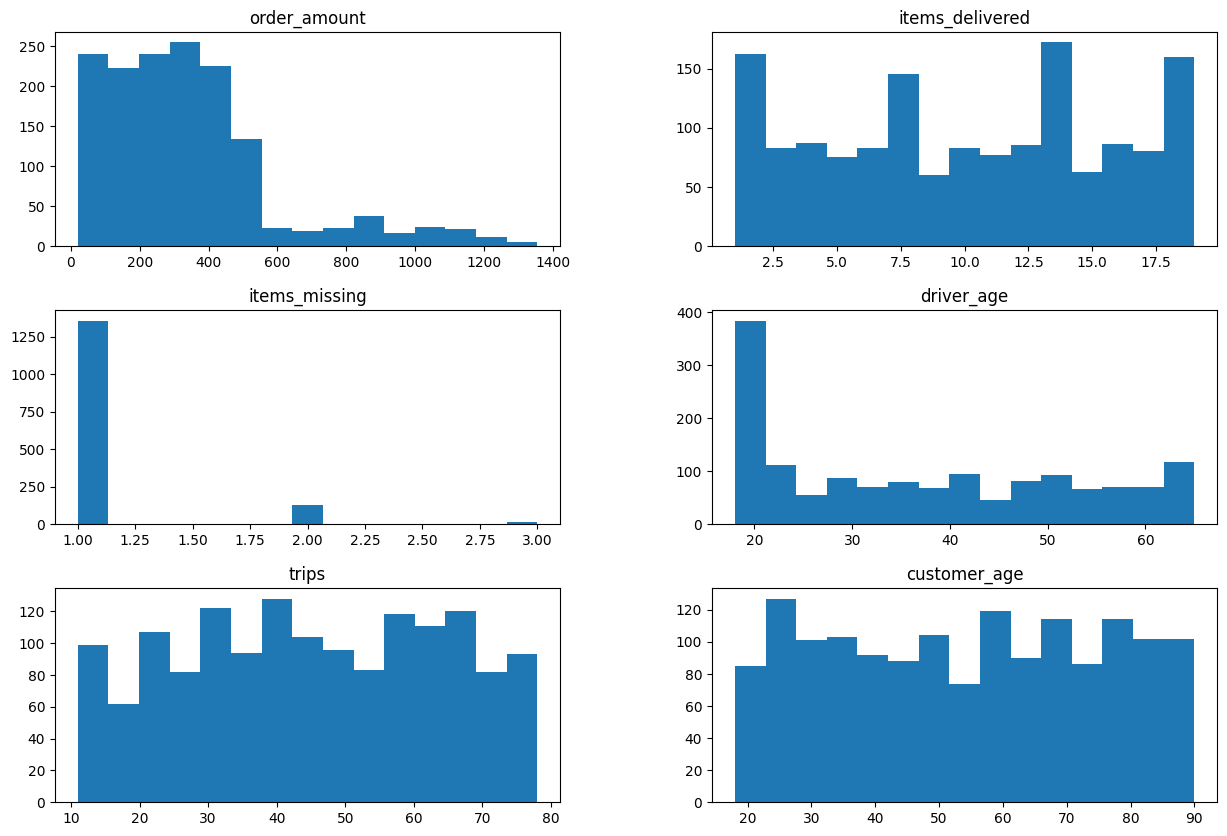

In [182]:
# Distribuição das variáveis
df.hist(bins=15, figsize=(15,10), grid=False)

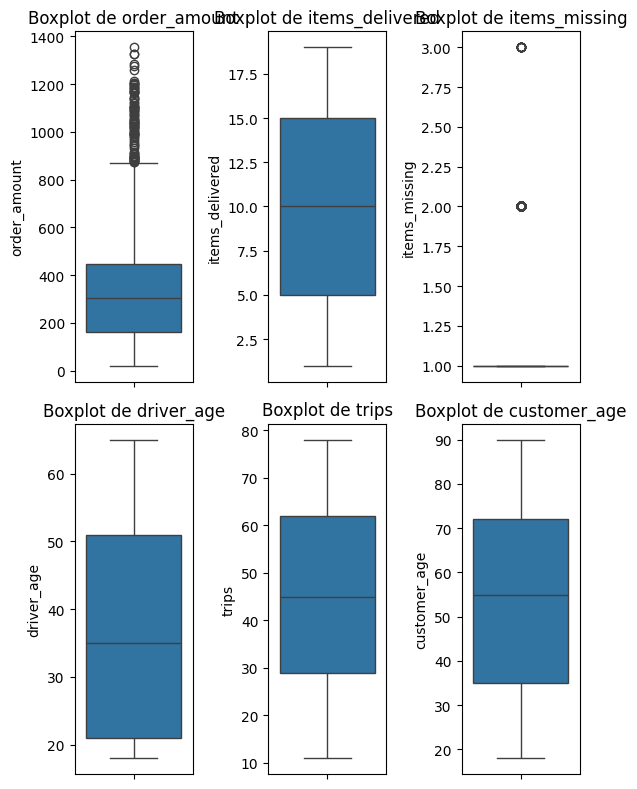

In [183]:
# Outliers

# Criando gráficos separados para cada variável
variables = ['order_amount', 'items_delivered', 'items_missing', 'driver_age', 'trips', 'customer_age']

plt.figure(figsize=(6, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)  # 2 linhas e 3 colunas
    sns.boxplot(y=df[var])
    plt.title(f'Boxplot de {var}')
    plt.tight_layout()  # Ajuste automático para evitar o corte de elementos

plt.show()

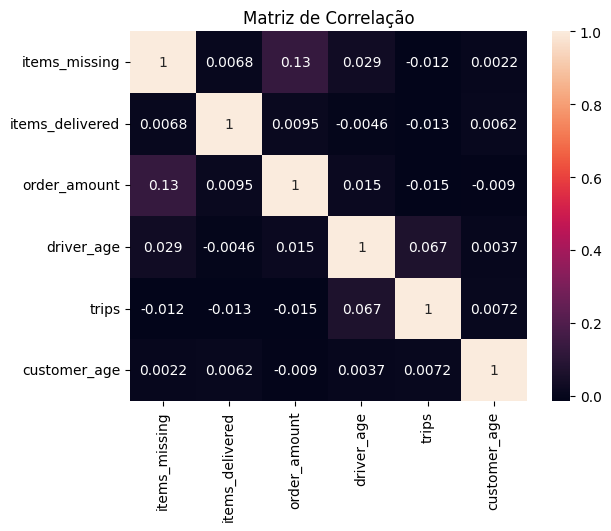

In [184]:
# Correlações entre as variáveis
corr = df_original[['items_missing', 'items_delivered', 'order_amount', 'driver_age', 'trips', 'customer_age']].corr()

sns.heatmap(corr, annot=True)
plt.title('Matriz de Correlação')
plt.show()


In [185]:
# Dados Nulos
print(df.isnull().sum())

order_id              0
date                  0
order_amount          0
region                0
items_delivered       0
items_missing         0
delivery_hour         0
driver_id             0
customer_id           0
product_id_1          0
product_id_2       1358
product_id_3       1483
driver_name           0
driver_age            0
trips                 0
customer_name         0
customer_age          0
dtype: int64


#### ✅ Resumo - Data Understanding  

Foram carregados e visualizados os dados com ênfase em entender o tamanho e estrutura do conjunto.  
A filtragem do dataframe com pedidos com itens faltando foi definida para direcionar as próximas análises de possíveis fraudes.
Já são possíveis ter um direcionamento, analisando a correlação das variáveis.  

A ordem de correlação com itens faltantes segue essa ordem:
- Valor da ordem
- Idade do motorista
- Quantidade de itens entregues
- Idade do cliente

Mas ainda não é possível tirar nenhuma conclusão, essa é apenas a primeira etapa para entendimento dos dados... Continuaremos os trabalhos!

### 3. Modeling - Identificação de Padrões de Fraude

Como a matriz de correlação de pearson feita anteriormente trouxe um resultado pouco significativo, onde a maior correlação é entre items_missing e order_amount trazendo 0.13 de correlação.
Vamos seguir por outro caminho.

Vamos explorar uma análise temporal.

C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\199705115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_datetime(df['delivery_hour'], format='%H:%M:%S').dt.hour
C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\199705115.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['hour'], bins=24, kde=True, palette='viridis') # Adicionei palette para consistência, embora histplot use cor única
C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\199705115.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y='fraud_rate', dat

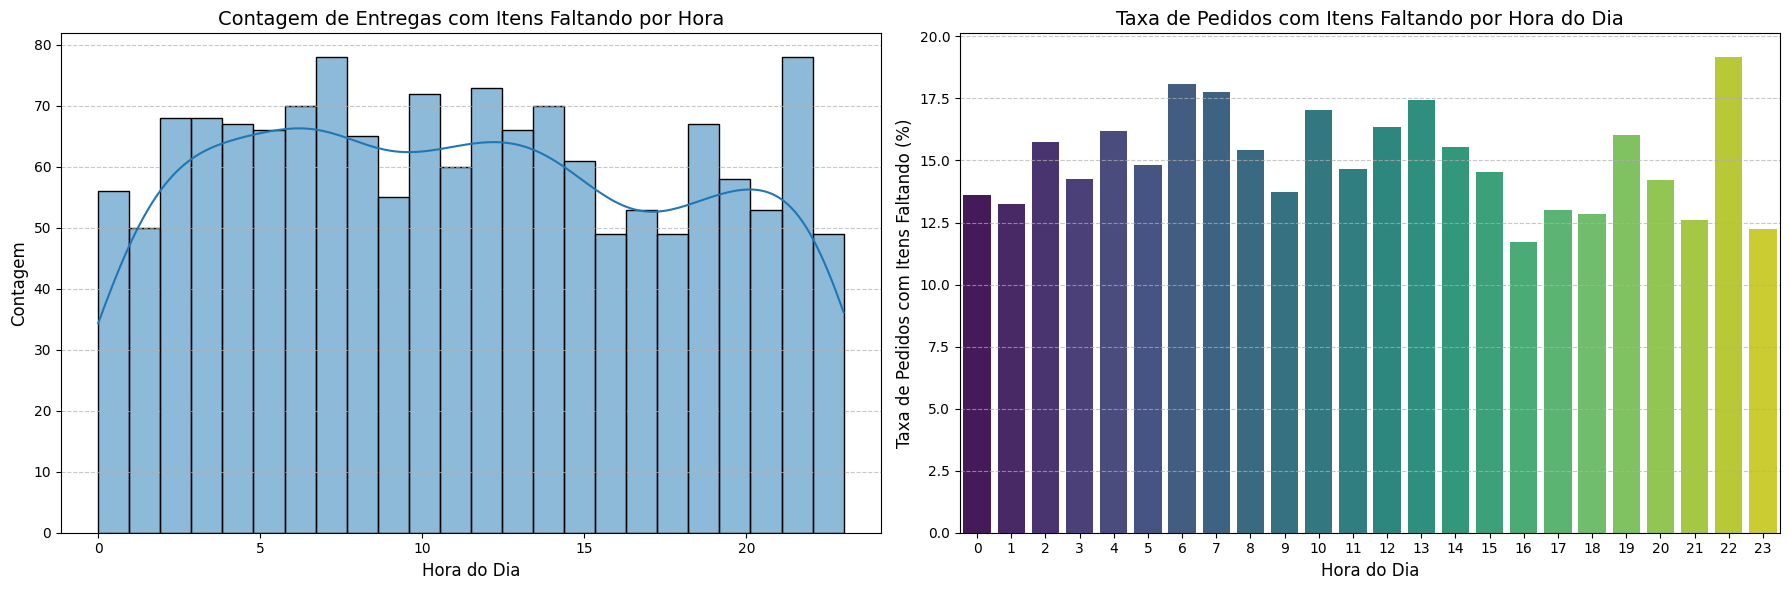

In [186]:
# Cria a coluna 'hour' para df (assumindo que já está filtrado para itens faltando)
df['hour'] = pd.to_datetime(df['delivery_hour'], format='%H:%M:%S').dt.hour

# Cria a coluna 'hour' para df_original (todas as ordens)
df_original['hour'] = pd.to_datetime(df_original['delivery_hour'], format='%H:%M:%S').dt.hour

# Agrupa por hora e calcula o total de pedidos e o total de pedidos com itens faltando
hourly_fraud_data = df_original.groupby('hour').agg(
    total_orders=('order_id', 'count'),
    missing_orders_count=('items_missing', lambda x: (x > 0).sum())
).reset_index()

# Calcula a taxa de fraude
hourly_fraud_data['fraud_rate'] = (hourly_fraud_data['missing_orders_count'] / hourly_fraud_data['total_orders']) * 100


# --- Criação dos Gráficos Lado a Lado ---
plt.figure(figsize=(18, 6)) # Aumenta o tamanho da figura para acomodar dois gráficos

# Primeiro Subplot: Histograma das Entregas com Itens Faltando por Hora
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1º gráfico
sns.histplot(df['hour'], bins=24, kde=True, palette='viridis') # Adicionei palette para consistência, embora histplot use cor única
plt.title('Contagem de Entregas com Itens Faltando por Hora', fontsize=14)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Segundo Subplot: Taxa de Pedidos com Itens Faltando por Hora do Dia
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2º gráfico
sns.barplot(x='hour', y='fraud_rate', data=hourly_fraud_data, palette='viridis')
plt.title('Taxa de Pedidos com Itens Faltando por Hora do Dia', fontsize=14)
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Taxa de Pedidos com Itens Faltando (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

In [187]:
print("\nDataFrame com a Taxa de Pedidos com Itens Faltando por Hora:")
print(hourly_fraud_data.sort_values(by='fraud_rate', ascending=False))


DataFrame com a Taxa de Pedidos com Itens Faltando por Hora:
    hour  total_orders  missing_orders_count  fraud_rate
22    22           407                    78   19.164619
6      6           387                    70   18.087855
7      7           439                    78   17.767654
13    13           384                    67   17.447917
10    10           423                    72   17.021277
12    12           446                    73   16.367713
4      4           414                    67   16.183575
19    19           418                    67   16.028708
2      2           432                    68   15.740741
14    14           450                    70   15.555556
8      8           422                    65   15.402844
5      5           445                    66   14.831461
11    11           409                    60   14.669927
15    15           420                    61   14.523810
3      3           477                    68   14.255765
20    20           408    

No primeiro gráfico é exibido apenas ordens das ordens faltantes podendo enxergar um pico as 06 da manhã e as 22 da noite sendo o volume total de entregas com fraude.  
O segundo gráfico junto a tabela imprime a taxa percentual de pedidos com itens faltando por hora em relação a todas as entregas, pra que tenha certeza que o primeiro resultado não seja apenas decorrente de maior entrega nesse horário, portanto mais fraudes, com a segunda análise é possível confirmar os horários de maior risco.

Ainda se tratando de tempo, temos a coluna que exibe a data de entrega, podendo fazer uma análise se o risco aumenta em períodos sazonais.  

Datas específicas em 2023:

Páscoa: 9 de abril  
Dia das Mães: 14 de maio  
Dia dos Namorados: 12 de junho  
Dia dos Pais: 13 de agosto  
Dia das Crianças: 12 de outubro  
Black Friday: 24 de novembro  
Natal: 25 de dezembro  

Os meses de Março, Maio, Julho, Agosto e Novembro apresentam as maiores contagens de pedidos com itens faltando, todos acima de 130 ocorrências. Novembro, em particular, se destaca com um número elevado.

C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\3123547624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\3123547624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_num'] = df['date'].dt.month
C:\Users\mateu\AppData\Local\Temp\ipykernel_8524\3123547624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

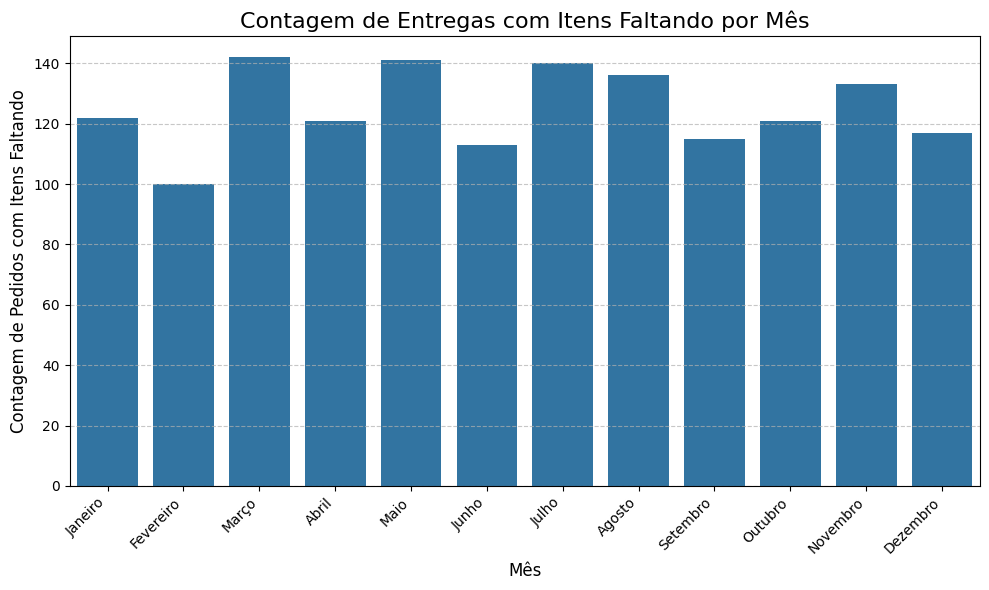

In [199]:
# Garantir datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month_num'] = df['date'].dt.month

# Mapeamento dos nomes
month_names = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril',
    5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto',
    9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
df['month_name'] = df['month_num'].map(month_names)

# Remover linhas com mês inválido (date ausente ou mal formatada)
df_valid = df.dropna(subset=['month_name'])

# Ordem correta dos meses
month_order = [month_names[i] for i in sorted(month_names.keys())]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='month_name', data=df_valid, order=month_order)
plt.title('Contagem de Entregas com Itens Faltando por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Contagem de Pedidos com Itens Faltando', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Os meses de Março, Maio, Julho, Agosto e Novembro apresentam as maiores contagens de pedidos com itens faltando,  
todos acima de 130 ocorrências. Porém nenhum impacto dos feriados selecionados parece ter algum impacto significativo.

In [ ]:
def exibe_top_tail(series, nome):
    print(f"\n{nome}:")
    display(pd.concat([series.head(3), series.tail(3)]))

exibe_top_tail(df_produto['product_name'].value_counts(), "Produtos com Itens Faltantes")
exibe_top_tail(df_produto['category'].value_counts(), "Categorias com Itens Faltantes")
exibe_top_tail(df_produto['price'].value_counts(), "Preços dos Itens Faltantes")
exibe_top_tail(df['order_amount'].value_counts(), "Valores das Ordens com Itens Faltantes")
exibe_top_tail(df['region'].value_counts(), "Regiões com Itens Faltantes")
exibe_top_tail(df['items_delivered'].value_counts(), "Qtde de Itens Entregues nas Ordens Faltantes")

exibe_top_tail(df['driver_id'].value_counts(), "Entregadores com Itens Faltantes")
# 1. Contar quantas vezes cada entregador aparece
ocorrencias_entregador = df['driver_id'].value_counts()
# # 2. Identificar os entregadores com 3 ou mais ocorrências
entregadores_excluir = ocorrencias_entregador[ocorrencias_entregador >= 3].index
# # 3. Filtrar o DataFrame para remover essas linhas
df_sem_entregadores_frequentes = df[~df['driver_id'].isin(entregadores_excluir)]
# 4. Exibir o DataFrame resultante
print("\nDataFrame sem entregadores com 3 ou mais ocorrências:", len(df_sem_entregadores_frequentes))

exibe_top_tail(df['customer_id'].value_counts(), "Clientes com Itens Faltantes")
exibe_top_tail(df['driver_age'].value_counts(), "Idade dos Entregadores com Itens Faltantes")
exibe_top_tail(df['trips'].value_counts(), "Qtde de Entregas dos Entregadores com Itens Faltantes")




Produtos com Itens Faltantes:


product_name
Chicken Breast       19
Ground Coffee        19
Cheddar Cheese       18
Samsung QLED TV       6
Garmin Forerunner     6
Croutons              5
Name: count, dtype: int64


Categorias com Itens Faltantes:


category
Pantry         429
Electronics    259
Supermarket    230
Bakery          73
Beverages       35
Household       10
Name: count, dtype: int64


Preços dos Itens Faltantes:


price
12.53     29
3.85      20
5.93      19
710.27     6
840.38     6
13.31      5
Name: count, dtype: int64


Valores das Ordens com Itens Faltantes:


order_amount
290.68    2
270.52    2
480.00    2
52.34     1
221.69    1
131.14    1
Name: count, dtype: int64


Regiões com Itens Faltantes:


region
Altamonte Springs    231
Clermont             219
Apopka               217
Orlando              212
Kissimmee            204
Sanford              203
Name: count, dtype: int64


Qtde de Itens Entregues nas Ordens Faltantes:


items_delivered
1     89
13    87
4     87
8     64
15    63
9     60
Name: count, dtype: int64


Entregadores com Itens Faltantes:


driver_id
WDID10524    4
WDID10058    4
WDID10072    4
WDID10686    3
WDID10679    3
WDID10667    3
Name: count, dtype: int64


Clientes com Itens Faltantes:


customer_id
WCID5820    7
WCID5685    7
WCID5007    6
WCID5259    1
WCID5512    1
WCID5088    1
Name: count, dtype: int64


Idade dos Entregadores com Itens Faltantes:


driver_age
18    140
19    136
22     72
53     14
46     13
25     12
Name: count, dtype: int64


Qtde de Entregas dos Entregadores com Itens Faltantes:


trips
55    40
45    36
41    35
51    10
38    10
26    10
Name: count, dtype: int64

### 4. Evaluation - Avaliação de Causas

Várias análises não geraram grandes conclusões, mas existem alguma tendências que precisam ser destacadas

#### 📊 **Análise Correlação**
Correlação muito baixa entre as variáveis, descartando mesmo qualquer tendência indicada pela matriz de correlação de Pearson.

#### 🕒 **Análise por hora**
As horas com a maior taxa de itens faltando são por volta das 22h (10 da noite), com uma taxa próxima a 19%.

Outro pico significativo ocorre em torno das 6h (6 da manhã), com uma taxa acima de 18%.

Horas como 7 da manhã, 10 da manhã e 13h (1 da tarde) também apresentam taxas elevadas, em torno de 16-17%.

#### 📅 **Análise por Data**
Outra análise que apresentou pouco resultado em relação a esse problema foi a sazonalidade, com uma idéia que próximos a feriados tivesse um alto índice de fraude, não foi confirmado essa tendência.

#### 📦 **Análise de Itens/Categoria**
Ao verificar os itens com maior ocorrência, a amostra fica significativamente baixa, sendo que são 1500 ocorrências, o primeiro produto tem apenas 19 ocorrências, mas ao verificar as categorias, há um corte bem significativo do primeiro para o segundo - Pantry(429) e Eletronics(259).

#### 💵 **Análise por Preço/Valor total da ordem**
Aqui a amostra fica pouco significativa considerando o total de ocorrências.

#### 🌍 **Análise de regiões**
As regiões tem uma distribuição equilibrada, com todas acima de 200 ocorrências, sendo menos de 5% de diferença da primeira região pra a última

#### 📋 **Quantidade de Itens na ordem**
Ordens com apenas uma quantidade são mais problemáticas, mas curiosamente ordens com 13 itens ficam em segundo lugar nas ocorrências de fraude.

#### 👴 **Idade dos entregadores**
Entregadores de 18 a 22 são responsáveis por 20% das fraudes.

#### 🚚 **Quantidade de entregas**
Quanto mais entregas, mais índices de fraudes, podendo ser apenas erros, diretamente proporcional sendo que entregadores mais antigos tem mais ocorrências.

#### 👩‍✈️ **Análise entregadores**
Todos os entregadores dessa amostra tiveram 3/4 ocorrências.

### 5. Deployment - Recomendações / Propostas de Melhoria de Dados

Esse problema possui várias vertentes, a fraude pode ser pelo cliente, pelo entregador ou uma falha de sistema, sendo assim, será propostas recomendações que os dados indicam, podendo ter sanções ou atividades extras para os clientes ou entregadores:

**1ª Recomendação**  
A maior taxa de fraudes ocorre por volta das 22h (19%) e por volta da 06 (18%), portanto deve se ter mais atividades que protejam ambos os lados, nos pedidos desses horários, será necessário ter uma senha enviada para o e-mail do cliente, onde o entregador cadastrará em nosso sistema. Será obrigatório a retirada do próprio cliente, não podendo ser retirado por outra pessoa, caso acontece algum produto faltante sem cumprimento, cliente deverá informar mais detalhes do pedido.

**2ª Recomendação**  
45,87% das fraudes são nas categorias de Pantry (alimentos não perecíveis) e Electronics (Eletrônicos).
Como Alimentos tem baixo valor agregado e Eletrônicos tem alto valor agregado, a abordagem deve ser diferente, para Eletrônicos deve ter um redobramento de atenção no processo interno, todos os produtos dessa categoria ficam em uma embalagem diferente, e processo de registro por câmera podendo ser descartado a cada 30 dias, também deverá ser recolhido uma confirmação de recebimento, assinatura digital do cliente ao receber o produto.
Para Alimentos é um pouco mais difícil, pois devoluções não são aceitas e normalmente é enviado outro no lugar automaticamente, como é um produto barato, colocar atividades de verificação por parte do cliente e do entregador fica muito custoso, portanto a idéia é aumentar o valor agregado dos produtos investindo em packs de 10, 12, 15. Aumentando o peso e o valor, é possível tornar a fraude mais dificultosa.

**3ª Recomendação**  
Todas os entregadores envolvidos nas ordens com produtos não entregues tiveram reincidência de 3 a 4 vezes. Criar uma política de reincidência de produtos não entregues para entregadores, podendo ser reavaliado no programa submetendo novas documentações, exclusão das categorias mais sensíveis ou desligamento após 4 reincidências.

**4ª Recomendação**  
Entregadores de 18 a 22 são responsáveis por 20% dos pedidos com fraudes, portanto ter uma política de cadastramentos de novos entregadores mais rigorosa para essa faixa etária.